In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## using code from https://github.com/tim-learn/SHOT
## & https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=DEfSbAA4QHas
## & https://github.com/youngryan1993/SFDA-Domain-Adaptation-without-Source-Data
# !pip3 install -r 'drive/My Drive/source-free-domain-adaptation/baselines/negation/requirements.txt'
!pip3 install torchviz
!pip3 install transformers==3.02

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=4d6fbf8106063a5992068558b87488a3d9879f16f5643f5ac36c433e2897c297
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
     |████████████████████████████████| 1.0MB 5.4MB/s 
     |████████████████████████████████| 1.1MB 12.4MB/s 
     |████████████████████████████████| 3.0MB 27.1MB/s 
     |████████████████████████████████| 890kB 54.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=945b4966665a7da48c109c12e4ae5661b314dccd280eae86805422b4b05f13a0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from tabulate import tabulate
import logging
import os
import argparse
import torch
import numpy as np
from torch.utils.data.dataset import Dataset
from transformers.data.processors.utils import InputExample, InputFeatures
from transformers.data.processors.glue import glue_convert_examples_to_features
from transformers.data.processors.utils import DataProcessor
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

labels = ["-1", "1"]
max_length = 128
logger = logging.getLogger(__name__)


In [ ]:
import argparse
import os, sys
import os.path as osp
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random, pdb, math, copy
from tqdm import tqdm
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix

In [ ]:
# Set the seed value all over the place to make this reproducible.
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
def seed_everything(seed=3000):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything()
train_min_step = 1000
train_lr=0.0001
train_weight_decay = 0.0005
train_momentum = 0.9
train_update_freq = 50
# for step, batch in enumerate(train_dataloader):
#   print(batch)

In [ ]:
import torch
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence
model_name = "tmills/roberta_sfda_sharpseed"

config = AutoConfig.from_pretrained(model_name,output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          config=config)

fixed_source_net = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                            config=config)
fixed_source_net.cuda()
for k,v in fixed_source_net.named_parameters():
  v.requires_grad = False

In [ ]:
import nltk
import re
from nltk.corpus import stopwords

def text_augmentation(lines,y_true_,extra_size_ratio=5):
  lt = 6
  rt = 3
  y_true_= y_true_.unsqueeze(1)
  p = re.compile('<e>.*</e>')
  concept_terms = []
  for line in lines:
    line=line[0]
    concept_terms.append(re.findall('<e>.*</e>', line)[0])
  sz = len(lines)
  for i in range(int(extra_size_ratio*sz)):
    idx = random.choice(range(sz))
    line = lines[idx][0]
    n=len(line)
    ## taking only a part of sentence that contains the marked term with max 6 words on left and 3 word on right
    m=p.search(line)
    (start,end) = m.span()

    # left = line[:start]
    # left_words = left.split()
    # left_words = left_words[-min(lt,len(left_words)):]
    # left = ' '.join(left_words)

    # right = line[end:]
    # right_words = right.split()
    # right_words = right_words[:min(rt,len(right_words))]
    # right = ' '.join(right_words)

    # new_line = left+" "+m.group()+" "+right
    # lines.append([new_line])
    ## --------
    ## replacing concept term with some other concept term
    idx2 = random.choice(range(len(concept_terms)))
    new_line2 = line[:start] + concept_terms[idx2] + line[end:]
    lines.append([new_line2])
    # lines.append([line])
    # print(torch.tensor([y_true_[idx].cpu().numpy()]))
    y_true_ = torch.vstack((y_true_,torch.tensor(y_true_[idx].cpu().numpy()).cuda()))
    ## -------
    # print("original line : ",line)
    # print("new first line : ",new_line)
    # print("new second line : ",new_line2)
  y_true_ = y_true_.squeeze(1)
  return lines,y_true_

class NegationDataset(Dataset):
    def __init__(self, features):
        self.features = features
        self.label_list = ["-1", "1"]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i) -> InputFeatures:
        return self.features[i]

    def get_labels(self):
        return self.label_list


    @classmethod
    def from_tsv(cls, tsv_file, tokenizer,flag=0,idx = [],y_true_ = [],extra_ratio=0):
        """Creates examples for the test set."""
        lines = DataProcessor._read_tsv(tsv_file)
        # print(lines)
        pos_lines = []
        neg_lines = []
        extra_lines  = 0
        pos_n = 0
        neg_n = 0
        if idx!=[]:
          lines = [line for (i,line) in enumerate(lines) if i in idx]
          pos_lines = [line for (i,line) in enumerate(lines) if y_true_[i]==1]
          neg_lines = [line for (i,line) in enumerate(lines) if y_true_[i]==0]
          pos_n = len(pos_lines)
          neg_n = len(neg_lines)
          extra_pos_ratio = ((len(neg_lines)/len(pos_lines))*(1+extra_ratio)-1)
          extra_neg_ratio = extra_ratio
          # print(extra_pos_ratio)

        # print(lines)
        if flag==1:
          pos_y_true_ = torch.ones(pos_n).cuda()
          neg_y_true_ = torch.zeros(neg_n).cuda()
          pos_lines,pos_y_true_ = text_augmentation(pos_lines,pos_y_true_,extra_pos_ratio)
          neg_lines,_ = text_augmentation(neg_lines,neg_y_true_,extra_neg_ratio)
          lines = []
          # print(len(pos_y_true_))
          y_true_ = pos_y_true_.unsqueeze(1)
          for line in pos_lines:
            lines.append(line)
          for line in neg_lines:
            lines.append(line)
            y_true_ = torch.vstack((y_true_,torch.tensor(0).cuda()))
          
          y_true_ = y_true_.squeeze(1)
            
        examples = []
        for (i, line) in enumerate(lines):
            # if idx==None or i in idx:
            guid = 'instance-%d' % i
            if line[0] in labels:
                text_a = '\t'.join(line[1:])
            else:
                text_a = '\t'.join(line)
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=None))

        features = glue_convert_examples_to_features(
            examples,
            tokenizer,
            max_length=max_length,
            label_list=labels,
            output_mode='classification',
        )
        return cls(features),y_true_
train_dataset,_ = NegationDataset.from_tsv('drive/My Drive/source-free-domain-adaptation/practice_text/negation/train.tsv', tokenizer)

In [ ]:


## preprocesses inputs from the text that can be directly fed to model

input_ids = []
attention_masks = []
output_label = []
y_true = torch.tensor([]).cuda()
entropyl = torch.tensor([]).cuda()
m=torch.nn.Softmax(dim=1)
cnt=0
for feat in train_dataset.features:
  input_ids.append(feat.input_ids)
  attention_masks.append(feat.attention_mask)
  out = fixed_source_net(torch.tensor([feat.input_ids]).cuda(),torch.tensor([feat.attention_mask]).cuda())

  pred = m(out[0])
  # print(pred)
  entropy = torch.sum(- pred * torch.log(pred), dim=1, keepdim=True)
  entropy_norm = entropy / np.log(pred.size(1))
  entropy_norm = entropy_norm.squeeze(1)
  # print(entropy_norm)
  entropyl = torch.cat((entropyl,entropy_norm),0)
  z = torch.argmax(out[0],dim=1)
  z = z.type(torch.cuda.LongTensor)
  y_true = torch.cat((y_true,z),0)
  # print(y_true)

print(entropyl)
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
# pos_id = input_ids[y_true==1]
# pos_mask = attention_masks[y_true==1]
# neg_id = input_ids[y_true==0]
# neg_mask = attention_masks[y_true==0]
# pos_size = pos_id.shape[0]
# negn = range(neg_id.shape[0])
# idx = random.choices(negn,k=pos_size)
# neg_red_id = neg_id[idx]
# neg_red_mask = neg_mask[idx]
# input_red_ids = torch.cat((pos_id,neg_red_id),0)

# attention_red_mask = torch.cat((pos_mask,neg_red_mask),0)

tensor([0.0259, 0.0041, 0.0039,  ..., 0.0041, 0.1138, 0.0042], device='cuda:0')


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

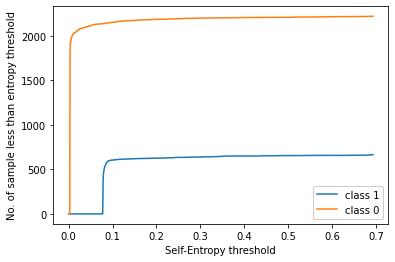

In [ ]:
import matplotlib.pyplot as plt
pos = (y_true==1)
neg = (y_true==0)
entropyl_ = entropyl*np.log(2) 
entropyl_pos = entropyl_[pos]
entropyl_neg = entropyl_[neg]
entropys = np.linspace(0, math.log(2), 5000)
y1 = [len(entropyl_pos[entropyl_pos<x]) for x in entropys]
y2 = [len(entropyl_neg[entropyl_neg<x]) for x in entropys]
print(y1)
print(y2)
plt.plot(entropys,y1,label='class 1')
plt.plot(entropys,y2,label = 'class 0')
plt.xlabel('Self-Entropy threshold')
plt.ylabel('No. of sample less than entropy threshold')
plt.legend(framealpha=1, frameon=True);
plt.savefig('entropy.jpg')
plt.show(1)


In [ ]:
import numpy as np
l = np.array([0.8588,0.8501,.8526,0.8541])
l1 = np.array([0.903,0.8718,0.873,0.877])
l2 = np.array([0.818,0.829,0.833,0.8322])
np.mean(l2),np.std(l2)

(0.82805, 0.005992286708761543)

In [ ]:
# entropyl_sorted = torch.sort(entropyl)
# torch.std(entropyl_sorted.values)
# torch.quantile(entropyl_sorted.values,torch.tensor([0.25,0.33,0.5,0.67,0.75]).cuda())
# pos_entropy_max = torch.sort(entropyl[y_true==1]).values[499]
# neg_entropy_max = torch.sort(entropyl[y_true==0]).values[499]
pos_entropyl = torch.sort(entropyl[y_true==1])
neg_entropyl = torch.sort(entropyl[y_true==0])
pos_threshold = torch.quantile(pos_entropyl.values,torch.tensor([0.5]).cuda())
neg_threshold = torch.quantile(neg_entropyl.values,torch.tensor([0.5]).cuda())
# pos_half_entropy = 
# mask = (entropyl<=0.113)
# idx = torch.where(mask==True)[0]
# # print(len(idx))
print(pos_threshold)
pos_mask = (y_true==1) & (entropyl<=pos_threshold)
print(len(input_ids[pos_mask]))
neg_mask = (y_true==0) & (entropyl<pos_threshold)
print(len(input_ids[neg_mask]))


mask = (((entropyl<pos_threshold) & (y_true==1)) | ((entropyl<pos_threshold) & (y_true==0)))
idx = torch.where(mask==True)[0]
# new_train_dataset = NegationDataset.from_tsv('drive/My Drive/source-free-domain-adaptation/practice_text/negation/train.tsv', tokenizer,1,idx.tolist())
y_true_ = y_true[idx]
new_train_dataset,y_true_= NegationDataset.from_tsv('drive/My Drive/source-free-domain-adaptation/practice_text/negation/train.tsv', tokenizer,1,idx.tolist(),y_true_,3)
# print(len(y_true_[y_true_==1]),len(y_true_[y_true_==0]))
# idx = 
# entropyl_sorted

tensor([0.1129], device='cuda:0')
333
2137


In [ ]:
# len(y_true_)
print(len(y_true_[y_true_==0]))
print(len(y_true_[y_true_==1]))
print(len(new_train_dataset.features))

8548
8548
17096


In [ ]:
0.1/math.log(2)

0.14426950408889636

In [ ]:
new_input_ids = []
new_attention_masks = []

for feat in new_train_dataset.features:
  new_input_ids.append(feat.input_ids)
  new_attention_masks.append(feat.attention_mask)

new_input_ids = torch.tensor(new_input_ids)
new_attention_masks = torch.tensor(new_attention_masks)
y_true_ = torch.tensor(y_true_)
y_true_ = y_true_.type(torch.cuda.LongTensor)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
 
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
 
dataset = TensorDataset(new_input_ids, new_attention_masks,y_true_)
# dataset = TensorDataset(input_red_ids,attention_red_mask)
# dataset.tensors
batch_size=16 # 32
train_dataloader = DataLoader(
            dataset,  # The training samples.
            # sampler = RandomSampler(dataset), # Select batches randomly        ### was commented for 0.8759
            shuffle = True,  ### not here for 0.8759
            batch_size = batch_size # Trains with this batch size.
        )
APM_dataloader = DataLoader(
    dataset,
    batch_size = 16 # T
)
print(len(dataset))

17096


In [ ]:

def proto_augmentation(prototype_memory,prototype_memory_dict,num_prototype_,lb = 0.5,extra_size_ratio = 0.5):
  prototype_memory = []
  for cls in range(2):
    extra_prototype = np.empty((0,768), np.float32)
    l = prototype_memory_dict[cls]
    
    for i in range(int(extra_size_ratio*num_prototype_)):
      idx=random.sample(range(num_prototype_),2)
      new_prototype = (l[idx[1]]-l[idx[0]])*lb+l[idx[0]]
      extra_prototype = np.append(extra_prototype,np.array([new_prototype]),axis=0)
    prototype_memory_dict[cls] = np.concatenate((l,extra_prototype),axis = 0)
    prototype_memory.append(prototype_memory_dict[cls])
  num_prototype_ += int(extra_size_ratio*num_prototype_)
  prototype_memory = np.concatenate(prototype_memory,axis=0)

  return prototype_memory,prototype_memory_dict,num_prototype_


In [ ]:

import time
print(len(dataset))
def APM_ours(target_trainable_net):
  target_trainable_net = target_trainable_net.cuda()

  cnt=1
  available_cls = []
  h_dict = {}
  feat_dict = {}
  missing_cls = []
  after_softmax_numpy_for_emergency = []
  feature_numpy_for_emergency = []
  max_prototype_bound = 100
  start_time = time.time()
  m=torch.nn.Softmax(dim=1)

  for cls in range(2): ## number of classes and their cls
    h_dict[cls] = []
    feat_dict[cls] = []

  for dt in APM_dataloader:
    input_id = dt[0].cuda()
    attention_mask = dt[1].cuda()

    out = target_trainable_net(input_id,attention_mask=attention_mask)
    
    ### ?
    fc1 = out[1][-1][:,0,:]
    pred = m(out[0])

    after_softmax_numpy_for_emergency.append(pred.cpu().detach().numpy())
    feature_numpy_for_emergency.append(fc1.cpu().detach().numpy())
    pseudo_label = torch.argmax(pred, dim=1)
    pseudo_label = pseudo_label.cpu()
    entropy = torch.sum(- pred * torch.log(pred), dim=1, keepdim=True)
    entropy_norm = entropy / np.log(pred.size(1))
    entropy_norm = entropy_norm.squeeze(1)
    entropy_norm = entropy_norm.cpu()
    # diff = -torch.abs(out[0][:,0] - out[0][:,1])
    for cls in range(2):
      # stack H for each class
      cls_filter = (pseudo_label == cls)
      list_loc = (torch.where(cls_filter == 1))[0]
      num_element = list(list_loc.numpy())
      if len(list_loc) == 0:
          missing_cls.append(cls)
          continue
      available_cls.append(cls)
      filtered_ent = torch.gather(entropy_norm, dim=0, index=list_loc)
      filtered_feat = torch.gather(fc1.cpu(), dim=0, index=list_loc.unsqueeze(1).repeat(1, 768))
      h_dict[cls].append(filtered_ent.detach().numpy())
      feat_dict[cls].append(filtered_feat.cpu().detach().numpy())

  available_cls = np.unique(available_cls)
  # print(feat_dict[0],h_dict[0])
  # print(feat_dict[1],h_dict[1])
  prototype_memory = []
  prototype_memory_dict = {}
  after_softmax_numpy_for_emergency = np.concatenate(after_softmax_numpy_for_emergency, axis=0)
  feature_numpy_for_emergency = np.concatenate(feature_numpy_for_emergency, axis=0)
  max_top1_ent = 0
  for cls in available_cls:
    ents_np = np.concatenate(h_dict[cls], axis=0)
    ent_idxs = np.argsort(ents_np)
    top1_ent = ents_np[ent_idxs[0]]
    if max_top1_ent < top1_ent:
      max_top1_ent = top1_ent
      max_top1_class = cls

  class_protypeNum_dict = {}
  # max_prototype = 0
  max_prototype = 100
  # for cls in available_cls:
  #   ents_np = np.concatenate(h_dict[cls], axis=0)
  #   ents_np_filtered = (ents_np <= max_top1_ent)
  #   class_protypeNum_dict[cls] = ents_np_filtered.sum()

  #   if max_prototype < ents_np_filtered.sum():
  #     max_prototype = ents_np_filtered.sum()

  # if max_prototype > max_prototype_bound:
  #     max_prototype = max_prototype_bound

  # print(feat_dict)
  for cls in range(2):

    if cls in available_cls:
      ents_np = np.concatenate(h_dict[cls], axis=0)
      
      feats_np = np.concatenate(feat_dict[cls],axis=0)    # print(prototype_memory)xis=0)
      # print(feat_dict[cls])
      ent_idxs = np.argsort(ents_np)
      # print(ent_idxs,class_protypeNum_dict[cls])
    
      truncated_feat = feats_np[ent_idxs[:100]]
      # truncated_feat = feats_np[ent_idxs[:class_protypeNum_dict[cls]]]
      fit_to_max_prototype = np.concatenate([truncated_feat] * (int(max_prototype / truncated_feat.shape[0]) + 1),
                                            axis=0)
      fit_to_max_prototype = fit_to_max_prototype[:max_prototype, :]
      prototype_memory.append(fit_to_max_prototype)
      prototype_memory_dict[cls] = fit_to_max_prototype
    else:
      after_softmax_torch_for_emergency = torch.Tensor(after_softmax_numpy_for_emergency)
      emergency_idx = torch.argsort(after_softmax_torch_for_emergency, descending=True, dim=1)
      cls_emergency_idx = emergency_idx[:, cls]
      cls_emergency_idx = cls_emergency_idx[0]
      cls_emergency_idx_numpy = cls_emergency_idx.data.numpy()

      copied_features_emergency = np.concatenate(
          [np.expand_dims(feature_numpy_for_emergency[cls_emergency_idx_numpy], axis=0)] * max_prototype, axis=0)

      prototype_memory.append(copied_features_emergency)
      prototype_memory_dict[cls] = copied_features_emergency

  print("** APM update... time:", time.time() - start_time)
  
  prototype_memory = np.concatenate(prototype_memory, axis=0) ## check
  num_prototype_ = int(max_prototype)
  # print(num_prototype_,prototype_memory_dict,prototype_memory)
  return prototype_memory, num_prototype_, prototype_memory_dict

fixed_source_net.cuda()
# prototype_memory, num_prototype_, prototype_memory_dict = APM_ours(fixed_source_net)
# prototype_memory,prototype_memory_dict,num_prototype_ = proto_augmentation(prototype_memory,prototype_memory_dict,num_prototype_)

def check_if_updated(model1,model2):
  a=target_trainable_net.roberta.encoder.layer[10].attention.output.dense.weight
  b=fixed_source_net.roberta.encoder.layer[10].attention.output.dense.weight
  if np.array_equal(a.cpu().detach().numpy(),b.cpu().detach().numpy()):
    print("same")
  else:
    print("different")

# check_if_updated(fixed_source_net,target_trainable_net)
# del prototype_memory 


17096


In [ ]:
import math
def op_copy(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr0'] = param_group['lr']
    return optimizer

def lr_scheduler(optimizer, iter_num, max_iter, gamma=10, power=0.75):
    decay = (1 + gamma * iter_num / max_iter) ** (-power)
    # decay = 1/math.sqrt(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr0'] * decay
        param_group['weight_decay'] =0.0005
        param_group['momentum'] = 0.9
        param_group['nesterov'] = True
    return optimizer

def tensor_l2normalization(q):
    qn = torch.norm(q, p=2, dim=1).detach().unsqueeze(1)
    q = q.div(qn.expand_as(q))
    return q


In [ ]:
import copy 
model_name = "tmills/roberta_sfda_sharpseed"
# del config1,tokenizer1,target_trainable_net
config1 = AutoConfig.from_pretrained(model_name,output_hidden_states=True)
tokenizer1 = AutoTokenizer.from_pretrained(model_name,
                                          config=config1)

target_trainable_net = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                            config=config1)
target_trainable_net = target_trainable_net.cuda()
class classifier_head(nn.Module):
  def __init__(self):
      super().__init__()
      # self.dense = nn.Linear(in_features = 768,out_features = 768,bias=True)
      self.dense = copy.deepcopy(target_trainable_net.classifier.dense)
      # self.dropout = nn.Dropout(p=0.1, inplace = False)
      self.dropout = copy.deepcopy(target_trainable_net.classifier.dropout)
      # self.out_proj = nn.Linear(in_features = 768, out_features = 2,bias=True)
      self.out_proj = copy.deepcopy(target_trainable_net.classifier.out_proj)
  def forward(self, x):
      # take <s> token (equiv. to [CLS])
      # x = feature[:,0,:]
      x = self.dropout(x)
      x = self.dense(x)
      x = torch.tanh(x)
      x = self.dropout(x)
      x = self.out_proj(x)
      return x

classifier = classifier_head()
classifier = classifier.cuda() ### change

In [ ]:
# for k,v in target_trainable_net.named_parameters():
#   a = k.split(".")
#   if a[0]!="classifier" and a[1] not in ["embeddings","pooler"] and int(a[3])<=8:
#     v.requires_grad = False



In [ ]:

def load_testdata(file_name):
    test_dataset,_ = NegationDataset.from_tsv(file_name, tokenizer)

    input_ids = []
    attention_masks = []
    for feat in test_dataset.features:
        input_ids.append(feat.input_ids)
        attention_masks.append(feat.attention_mask)

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    print(input_ids.shape,attention_masks.shape)

    dataset = TensorDataset(input_ids, attention_masks,torch.arange(input_ids.size(0)))
    
    # batch_size=32 # 32
    test_dataloader = DataLoader(dataset, batch_size = batch_size)
    print(batch_size)
    return test_dataloader

In [ ]:

def predict(test_file,output_test_file,threshold = 0.5):
  # target_trainable_net = 
  # tokenizer =
  start=True
  test_dataloader = load_testdata(test_file)
  for data in test_dataloader:
    # out = fixed_source_net(data[0].cuda(),data[1].cuda())
    out = target_trainable_net(data[0].cuda(),data[1].cuda())
    if start:
        predict = out[0].cpu().detach().numpy()
        start = False
    else:
        predict = np.concatenate((predict,out[0].cpu().detach().numpy()))
  m=torch.nn.Softmax(dim=1)
  p = m(torch.tensor(predict))
  p1 = np.ones(p.shape[0],np.int)
  for i in range(p.shape[0]):
    prob = p[i][1]
    if prob>threshold:
      p1[i] = 1
    else:
      p1[i] = -1
  # predict = np.argmax(predict,1)
  with open(output_test_file, "w") as writer:
    logger.info("***** Test results *****")
    for index, item in enumerate(p1):
        writer.write("%s\n" % p1[index])

  return p1

# predict('drive/My Drive//source-free-domain-adaptation/practice_text/negation/dev.tsv','drive/My Drive//source-free-domain-adaptation/submission/negation/system.tsv')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('drive/My Drive/proto_aug')
target_trainable_net = AutoModelForSequenceClassification.from_pretrained('drive/My Drive/proto_aug').cuda()
pred = predict('drive/My Drive//source-free-domain-adaptation/practice_text/negation/dev.tsv','system.tsv')
# lines1 = DataProcessor._read_tsv('drive/My Drive/task1_test.tsv')
# lines1_ = []
# for line in lines1:
#   if line[0][0]=="\"":
#     lines1_.append([line[0][1:-1]])
#   else:
#     lines1_.append([line[0]]) 
# lines2 = DataProcessor._read_tsv('drive/My Drive//source-free-domain-adaptation/practice_text/negation/dev.tsv')



torch.Size([5545, 128]) torch.Size([5545, 128])
16


In [ ]:
# ids = [idx for idx,line in enumerate(lines2) if line in lines1]
# s= set([line[0] for line in lines1_])
# print(len(lines1_))
# ids = []
# s = set([])
# for line in lines1_:
#   for idx,ln in enumerate(lines2):
#     if ln==line:
#       ids.append(idx)
#       break
# print(len(ids))

# # for line in lines1:
# #   if line not in lines2:
# #     print(line)
# # residual = [line for line in lines2 if line not in lines1]
# test_true = np.loadtxt('drive/My Drive//source-free-domain-adaptation/practice_text/negation/dev_labels.txt',dtype=np.int32)
# test_true = test_true[ids]
# print(len(test_true[test_true==1]))
# print(f1_score(test_true,pred),precision_score(test_true,pred),recall_score(test_true,pred))

2773
2773
569
0.8801498127340824 0.9418837675350702 0.8260105448154658


In [ ]:
def read_tsv(file):
    output = []
    with open(file, 'r') as f_output:
        for record in f_output:
            output.append(int(record))
    return output

def score_negation(ref_domain,res_domain):
    ref = read_tsv(ref_domain)
    res = read_tsv(res_domain)
    assert len(ref) == len(res)
    trainable_f1_score = f1_score(ref,res)
    trainable_prec = precision_score(ref,res)
    trainable_recall = recall_score(ref,res)
    scores = [['trained',trainable_f1_score,trainable_prec,trainable_recall]]
    print(tabulate(scores,headers=['model','f1 score','precision','recall']))
    return trainable_f1_score,trainable_prec,trainable_recall



In [ ]:
test_dataloader = load_testdata('drive/My Drive//source-free-domain-adaptation/practice_text/negation/dev.tsv')
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix


squarer = lambda t: 1 if t>1 else 0
vfunc = np.vectorize(squarer)
def evaluation(test_dataloader,target_net,fixed_source_net,flag=0):
    
 
    if flag == 1:
      pred1 = np.array([])
      for itr in range(3,6):
        start=True
        target_net = AutoModelForSequenceClassification.from_pretrained('drive/My Drive/models_APM/'+'1_'+str(itr)+'/').cuda()
        for data in test_dataloader:
            out = target_net(data[0].cuda(),data[1].cuda())
            if start:
                predict = out[0].cpu().detach().numpy()
                start = False
            else:
                predict = np.concatenate((predict,out[0].cpu().detach().numpy()))
        predict = np.argmax(predict,1)
        print(predict)
        if itr==3:
          pred1 = predict
        else:
          pred1 = np.vstack([pred1,predict])
      
      predict = pred1.sum(axis=0)
      predict = vfunc(predict)
      print(predict)
    else:
      start=True
      # target_net = AutoModelForSequenceClassification.from_pretrained('drive/My Drive/models_APM/'+str(itr)+'_3/').cuda()
      for data in test_dataloader:
          out = target_net(data[0].cuda(),data[1].cuda())
          if start:
              predict = out[0].cpu().detach().numpy()
              start = False
          else:
              predict = np.concatenate((predict,out[0].cpu().detach().numpy()))
      predict = np.argmax(predict,1)
    # print(predict.shape)

    fixed_source_net = fixed_source_net.cuda()
    fixed_source_net.eval()
    start=True
    for data in test_dataloader:
        out1 = fixed_source_net(data[0].cuda(),data[1].cuda())
        if start:
            predict1 = out1[0].cpu().detach().numpy()
            start = False
        else:
            predict1 = np.concatenate((predict1,out1[0].cpu().detach().numpy()))
    predict1 = np.argmax(predict1,1)
    # print(predict1.shape)
 
    pred = np.array([0]*5545)
    for i in range(5545):
        pred[i] = labels[predict[i]]
    # print(pred.shape)
 
    pred1 = np.array([0]*5545)
    for i in range(5545):
        pred1[i] = labels[predict1[i]]
    # print(pred1.shape)
    
    test_true = np.loadtxt('drive/My Drive//source-free-domain-adaptation/practice_text/negation/dev_labels.txt',dtype=np.int32)
    # confusion_matrix(test_true,pred1),
    # ,confusion_matrix(test_true,pred)
    
    trainable_f1_score = f1_score(test_true,pred)
    trainable_prec = precision_score(test_true,pred)
    trainable_recall = recall_score(test_true,pred)
    scores = [['pretrained',f1_score(test_true,pred1),precision_score(test_true,pred1),recall_score(test_true,pred1)],
              ['trained',trainable_f1_score,trainable_prec,trainable_recall]]
    print(tabulate(scores,headers=['model','f1 score','precision','recall']))
    print(confusion_matrix(test_true,pred))
    print(confusion_matrix(test_true,pred1))
    return trainable_f1_score,trainable_prec,trainable_recall
  
def forward(y_logits, y_true):
    beta = 1
    epsilon = 1e-15
    # print(y_logits)
    y_pred = torch.sigmoid(y_logits)
    # m=torch.nn.Softmax(dim=1)
    # y_pred = m(y_logits)
    # print(y_pred)
    
    TP = (y_pred * y_true).sum(dim=1)
    FP = (y_pred * (1-y_true)).sum(dim=1)
    FN = ((1-y_pred) *  y_true).sum(dim=1)
    fbeta = (1 + beta**2) * TP / ((1 + beta**2) * TP + (beta**2) * FN + FP + epsilon)
    fbeta = fbeta.clamp(min=epsilon, max=1 - epsilon)
    return 1 - fbeta.mean()

# evaluation(test_dataloader,target_trainable_net,fixed_source_net)


torch.Size([5545, 128]) torch.Size([5545, 128])
16


In [ ]:
## training portion of the code
from torch.autograd import Variable
import copy 
import math
# def target_train(train_lr,train_update_freq):
# avg_acc = [0]*11
l=[]
for itr in range(1):
  del target_trainable_net,classifier
  target_trainable_net = AutoModelForSequenceClassification.from_pretrained(model_name,config=config1)
  target_trainable_net = target_trainable_net.cuda()
  classifier = classifier_head()
  classifier = classifier.cuda()
  for k,v in target_trainable_net.named_parameters():
    x = k.split('.')
    if x[0]=='classifier':
      v.requires_grad=False


  train_start_time=time.time()

  train_min_step = 3204#2650#1335#2670#930#188*3 ### 1000 originally
  train_lr=0.0005
  train_weight_decay = 0.0005
  train_momentum = 0.9
  train_update_freq = 96 #96 # changed from 10

  # target_trainable_net.train()
  optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, target_trainable_net.parameters()))+list(classifier.parameters()), 
                        lr=train_lr, weight_decay=train_weight_decay, momentum=train_momentum, nesterov=True)

  optimizer = op_copy(optimizer)
  global_step = 0
  best_acc = 0
  best_epoch = 0
  epoch_id = 0
  class_num =  2
  max_epoch = math.ceil((train_min_step*batch_size)/len(dataset))
  pt_memory_update_frequncy =  train_update_freq
  # eval_interval = 100
  cnt=0
  m=torch.nn.Softmax(dim=1)

  # fixed_source_net.train()
  classifier.train()

  # fixed_source_net.zero_grad()
  classifier.zero_grad()
  target_trainable_net.zero_grad()

  while global_step < train_min_step:
    epoch_id += 1
    max_iter = max_epoch * len(train_dataloader)
    # print(max_iter)
    epoch_start_time=time.time()

    for i, dt in enumerate(train_dataloader):
      # APM init/update
      # if (global_step) % pt_memory_update_frequncy == 0: ### change
      #     target_trainable_net.eval() ### change
      #     prototype_memory, num_prototype_,prototype_memory_dict = APM_ours(target_trainable_net)
          # prototype_memory,prototype_memory_dict,num_prototype_ = proto_augmentation(prototype_memory,prototype_memory_dict,num_prototype_) # Tried augmentation in prototype feature

      input_id = dt[0].cuda()
      attention_mask = dt[1].cuda()
      pseudo_label = dt[2].cuda()
      fixed_source_net.train()
      out_s = fixed_source_net(input_id,attention_mask=attention_mask)
      pseudo_label_s = torch.argmax(out_s[0], dim=1).cuda()
      pseudo_label_hot_s = torch.zeros(out_s[0].shape).cuda()
      pseudo_label_hot_s = pseudo_label_hot_s.scatter(1,pseudo_label_s.unsqueeze(1),1.0).cuda()
      ## trainable target model
      target_trainable_net.train()
      out_t = target_trainable_net(input_id,attention_mask=attention_mask)
      fc_t = out_t[1][-1][:,0,:] #target_trainable_net.roberta.pooler(out_t[1][-1])
      feature_embed_tensor = fc_t.cpu()
      
      
      logit_s2t = classifier(fc_t) ### change
      logit_t = out_t[0]

      
      
      # proto_feat_tensor = torch.Tensor(prototype_memory)
      # proto_feat_tensor = tensor_l2normalization(proto_feat_tensor)
      # batch_feat_tensor = tensor_l2normalization(feature_embed_tensor)

      # sim_mat = torch.mm(batch_feat_tensor, proto_feat_tensor.permute(1,0))
      # sim_mat = F.avg_pool1d(sim_mat.unsqueeze(0), kernel_size=num_prototype_, stride=num_prototype_).squeeze(0)# (B, #class)
      

      # pseudo_label_t = torch.argmax(sim_mat, dim=1).cuda()
      # # pseudo_label_hot_t = torch.zeros(sim_mat.shape).scatter(1,a.unsqueeze(1),1.0).cuda()
      # if not np.array_equal(pseudo_label_t.cpu().detach().numpy(),pseudo_label_s.cpu().detach().numpy()):
      #   # print(sim_mat,logit_t,pseudo_label_s,pseudo_label_t)
      #   cnt=cnt+1
      # # lr_scheduler(optimizer, iter_num=global_step, max_iter=max_iter)

      # # confidence-based filtering
      # arg_idxs = torch.argsort(sim_mat, dim=1, descending=True) # (B, #class)
      # first_group_idx = arg_idxs[:, 0]
      # second_group_idx = arg_idxs[:, 1]
      # first_group_feat = [prototype_memory_dict[int(x.numpy())] for x in first_group_idx]
      # first_group_feat_tensor = torch.tensor(np.concatenate(first_group_feat, axis=0)) # (B*P, 2048)
      # first_group_feat_tensor = tensor_l2normalization(first_group_feat_tensor)

      # second_group_feat = [prototype_memory_dict[int(x.numpy())] for x in second_group_idx]
      # second_group_feat_tensor = torch.tensor(np.concatenate(second_group_feat, axis=0)) # (B*P, 2048)
      # second_group_feat_tensor = tensor_l2normalization(second_group_feat_tensor)

      # feature_embed_tensor_repeat = torch.Tensor(np.repeat(feature_embed_tensor.cpu().detach().numpy(), repeats=num_prototype_, axis=0))
      # feature_embed_tensor_repeat = tensor_l2normalization(feature_embed_tensor_repeat)

      # first_dist_mat = 1 - torch.mm(first_group_feat_tensor, feature_embed_tensor_repeat.permute(1,0)) # distance = 1  - simialirty
      # second_dist_mat = 1 - torch.mm(second_group_feat_tensor, feature_embed_tensor_repeat.permute(1,0))

      # first_dist_mat = F.max_pool2d(first_dist_mat.permute(1,0).unsqueeze(0).unsqueeze(0), kernel_size=num_prototype_, stride=num_prototype_).squeeze(0).squeeze(0)# (B, #class)
      # second_dist_mat = -1*F.max_pool2d(-1* second_dist_mat.permute(1,0).unsqueeze(0).unsqueeze(0), kernel_size=num_prototype_, stride=num_prototype_).squeeze(0).squeeze(0)# (B, #class)

      # first_dist_vec = torch.diag(first_dist_mat) #(B)
      # second_dist_vec = torch.diag(second_dist_mat) # B
      # confidence_mask = ((first_dist_vec- second_dist_vec) < 0).cuda()
      
      
      # optimize target network using two types of pseudo labels
      ce_from_s2t = nn.CrossEntropyLoss()(logit_t,pseudo_label)
      # ce_from_s2t = forward(logit_t,pseudo_label_hot_s)
      # ce_from_s2t = nn.CrossEntropyLoss(reduction = 'none')(logit_t, pseudo_label_s).view(-1,1).squeeze(1)
      # ones = pseudo_label_s.sum(axis=0)
      # zeros = 16-ones
      # # # print(ce_from_s2t)
      # # # print(ones)
      # # # print(zeros)
      # # # print(pseudo_label_s)
      # # # print(1-pseudo_label_s)
      # # # print(torch.mean(ce_from_s2t*pseudo_label_s,dim=0,keepdim=True)*(16/ones))
      # # # print(torch.mean(ce_from_s2t*(1-pseudo_label_s),dim=0,keepdim=True)*(16/zeros))
      # if ones!=0 and zeros!=0:
      #   ce_from_s2t = (torch.mean(ce_from_s2t*pseudo_label_s,dim=0,keepdim=True)*(16/ones)+torch.mean(ce_from_s2t*(1-pseudo_label_s),dim=0,keepdim=True)*(16/zeros))/2
      # else:
      #   ce_from_s2t = torch.mean(ce_from_s2t, dim=0, keepdim=True)
      # ce_from_s2t = nn.CrossEntropyLoss()(logit_t, pseudo_label_s)
      
      # ce_from_t = nn.CrossEntropyLoss(reduction='none')(logit_t, pseudo_label_t).view(-1, 1).squeeze(1)
      # ce_from_t = torch.mean(ce_from_t*confidence_mask, dim=0, keepdim=True)*(16/confidence_mask.sum(axis=0))
      
      # alpha = np.float(2.0 / (1.0 + np.exp( -0.08* global_step / float(train_min_step//2))) - 1.0)   ### 0.8 for 0.8759 ## changed from -0.08 to -0.8
      # alpha = 0
      ce_total = ce_from_s2t
      # ce_total = (1 - alpha)*ce_from_s2t + alpha*ce_from_t
      if global_step%2==0:
        batch_loss = ce_total
      else:
        batch_loss+=ce_total
      global_step+=1 
      if global_step%2==0:
        # print(optimizer.param_groups[0]['lr'])
        optimizer.zero_grad()
        batch_loss /= 2
        batch_loss.backward(retain_graph=True)
        # print(global_step,batch_loss)
        optimizer.step()
        lr_scheduler(optimizer, iter_num=global_step, max_iter=max_iter)
      # optimizer.zero_grad()
      # # # ce_from_s2t.backward(retain_graph=True)
      # ce_total.backward(retain_graph=True)
      # optimizer.step()
      # print(global_step,ce_from_s2t.cpu().detach().numpy())
      # print(global_step,alpha,ce_total.cpu().detach().numpy(),ce_from_s2t.cpu().detach().numpy(),ce_from_t.cpu().detach().numpy())
      # global_step+=1


    epoch_end_time=time.time()
    print("time taken for epoch no. {} is {}".format(epoch_id,epoch_end_time-epoch_start_time))
    target_trainable_net.eval()
    fixed_source_net.eval()
    fscore,prec,recall = evaluation(test_dataloader,target_trainable_net,fixed_source_net)
    l.append((fscore,prec,recall))
    print(l)
    # avg_acc[epoch_id]+=acc
    # target_trainable_net.save_pretrained('drive/My Drive/models_without_APM/'+str(itr)+'_'+str(epoch_id)+'/')
    # tokenizer1.save_pretrained('drive/My Drive/models_without_APM/'+str(itr)+'_'+str(epoch_id)+'/')
    # if epoch_id == 3:
    #   break
    
  #   if acc>best_acc:
  #     best_acc=acc
  #     best_epoch = epoch_id
  #     target_trainable_net.save_pretrained("drive/My Drive/best_model2")
  #     tokenizer1.save_pretrained("drive/My Drive/best_model2")
    
  print(cnt)
  train_end_time = time.time()
  print("Total_time taken : ",train_end_time-train_start_time)

# print(avg_acc)

time taken for epoch no. 1 is 488.34932136535645
model         f1 score    precision    recall
----------  ----------  -----------  --------
pretrained    0.834019     0.850746  0.817937
trained       0.884211     0.947692  0.8287
[[4379   51]
 [ 191  924]]
[[4270  160]
 [ 203  912]]
[(0.8842105263157896, 0.9476923076923077, 0.8286995515695067)]
time taken for epoch no. 2 is 487.50836515426636
model         f1 score    precision    recall
----------  ----------  -----------  --------
pretrained    0.834019     0.850746  0.817937
trained       0.882126     0.956021  0.818834
[[4388   42]
 [ 202  913]]
[[4270  160]
 [ 203  912]]
[(0.8842105263157896, 0.9476923076923077, 0.8286995515695067), (0.8821256038647343, 0.956020942408377, 0.8188340807174888)]
time taken for epoch no. 3 is 488.76512479782104
model         f1 score    precision    recall
----------  ----------  -----------  --------
pretrained    0.834019     0.850746  0.817937
trained       0.880153     0.945417  0.823318
[[4377  

In [ ]:
target_trainable_net.save_pretrained('drive/My Drive/proto_aug1')
tokenizer1.save_pretrained('drive/My Drive/proto_aug1')


('drive/My Drive/proto_aug1/vocab.json',
 'drive/My Drive/proto_aug1/merges.txt',
 'drive/My Drive/proto_aug1/special_tokens_map.json',
 'drive/My Drive/proto_aug1/added_tokens.json')

In [ ]:
# # lrs = [0.003,0.001,0.005,0.008]
# # APM_update_freqs = [100,50,200]
# # best_acc=0
# # best_config = ()
# # for lr in lrs:
# #   for freq in APM_update_freqs:
# #     acc,epoch = target_train(lr,freq)
# #     print(lr,freq,epoch,acc)
# #     if acc>best_acc:
# #       best_acc=acc
# #       best_config = (lr,freq,epoch)

# # print(best_config,best_acc)

# target_trainable_net.eval()
# fixed_source_net.eval()
# evaluation(test_dataloader,target_trainable_net,fixed_source_net)

In [ ]:
# target_trainable_net.save_pretrained("drive/My Drive/best_model_without_APM_0.8624")
# tokenizer1.save_pretrained("drive/My Drive/best_model_without_APM_0.8624")